## Installing the required packages

In [ ]:
!pip install transformers
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 68.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 4.3 MB/s eta 0:00:00


## Importing required libraries

In [ ]:
import pandas as pd
import os
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers.optimization import  Adafactor
import time
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import urllib.request
import zipfile
url = 'https://gitlab.com/shimorina/webnlg-dataset/-/archive/master/webnlg-dataset-master.zip?path=release_v3.0/en/train'
urllib.request.urlretrieve(url, 'web.zip')
with zipfile.ZipFile('web.zip', 'r') as zip_ref:
    zip_ref.extractall('web')
import glob
import os
import re
import xml.etree.ElementTree as ET
import pandas as pd
files = glob.glob("/content/web/webnlg-dataset-master-release_v3.0-en-train/release_v3.0/en/train/**/*.xml", recursive=True)
triple_re=re.compile('(\d)triples')
data_dct={}
for file in files:
    tree = ET.parse(file)
    root = tree.getroot()
    triples_num=int(triple_re.findall(file)[0])
    for sub_root in root:
        for ss_root in sub_root:
            strutured_master=[]
            unstructured=[]
            for entry in ss_root:
                unstructured.append(entry.text)
                strutured=[triple.text for triple in entry]
                strutured_master.extend(strutured)
            unstructured=[i for i in unstructured if i.replace('\n','').strip()!='' ]
            strutured_master=strutured_master[-triples_num:]
            strutured_master_str=(' && ').join(strutured_master)
            data_dct[strutured_master_str]=unstructured
mdata_dct={"prefix":[], "input_text":[], "target_text":[]}
for st,unst in data_dct.items():
    for i in unst:
        mdata_dct['prefix'].append('webNLG')
        mdata_dct['input_text'].append(st)
        mdata_dct['target_text'].append(i)


df=pd.DataFrame(mdata_dct)
df.to_csv('webNLG2020_train.csv')


## Loading the processed data

## Please look at the code [here](https://gist.github.com/MathewAlexander/d4853c2268a2293e479b773f0c317030) to preprocess the data

In [ ]:
#cd drive/My\ Drive/WebNLG2020/

/content/drive/My Drive/WebNLG2020


In [ ]:
train_df=pd.read_csv('/content/webNLG2020_train.csv', index_col=[0])

Trimming off a few data points and so that a batch would not leave any remainder, hence some lines of codes can be avoided (Okay, this might be a hackish way of doing it )

In [ ]:
train_df=train_df.iloc[  :35000,:]

In [ ]:
train_df=train_df.sample(frac = 1)

In [ ]:
batch_size=8
num_of_batches=len(train_df)/batch_size
num_of_epochs=4

In [ ]:
num_of_batches=int(num_of_batches)

Checking for the GPU availability

In [ ]:
if torch.cuda.is_available():
    dev = torch.device("cuda:0")
    print("Running on the GPU")
else:
    dev = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


## Loading the pretrained model and tokenizer

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base', return_dict=True)
#moving the model to device(GPU/CPU)
model.to(dev)

You are using the legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565


T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

## Initializing the Adafactor optimizer with parameter values suggested for t5

In [ ]:

optimizer = Adafactor(
    model.parameters(),
    lr=1e-3,
    eps=(1e-30, 1e-3),
    clip_threshold=1.0,
    decay_rate=-0.8,
    beta1=None,
    weight_decay=0.0,
    relative_step=False,
    scale_parameter=False,
    warmup_init=False
)








In [ ]:

from IPython.display import HTML, display

def progress(loss,value, max=100):
    return HTML(""" Batch loss :{loss}
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(loss=loss,value=value, max=max))

In [ ]:
num_of_epochs=1

## Training the model

In [ ]:
#Sets the module in training mode
model.train()

loss_per_10_steps=[]
for epoch in range(1,num_of_epochs+1):
  print('Running epoch: {}'.format(epoch))

  running_loss=0

  out = display(progress(1, num_of_batches+1), display_id=True)
  for i in range(num_of_batches):
    inputbatch=[]
    labelbatch=[]
    new_df=train_df[i*batch_size:i*batch_size+batch_size]
    for indx,row in new_df.iterrows():
      input = 'WebNLG: '+row['input_text']+'</s>'
      labels = row['target_text']+'</s>'
      inputbatch.append(input)
      labelbatch.append(labels)
    inputbatch=tokenizer.batch_encode_plus(inputbatch,padding=True,max_length=400,return_tensors='pt')["input_ids"]
    labelbatch=tokenizer.batch_encode_plus(labelbatch,padding=True,max_length=400,return_tensors="pt") ["input_ids"]
    inputbatch=inputbatch.to(dev)
    labelbatch=labelbatch.to(dev)

    # clear out the gradients of all Variables
    optimizer.zero_grad()

    # Forward propogation
    outputs = model(input_ids=inputbatch, labels=labelbatch)
    loss = outputs.loss
    loss_num=loss.item()
    logits = outputs.logits
    running_loss+=loss_num
    if i%10 ==0:
      loss_per_10_steps.append(loss_num)
    out.update(progress(loss_num,i, num_of_batches+1))

    # calculating the gradients
    loss.backward()

    #updating the params
    optimizer.step()

  running_loss=running_loss/int(num_of_batches)
  print('Epoch: {} , Running loss: {}'.format(epoch,running_loss))


Running epoch: 1


Epoch: 1 , Running loss: 0.5019446459702083


## Plotting the loss over time

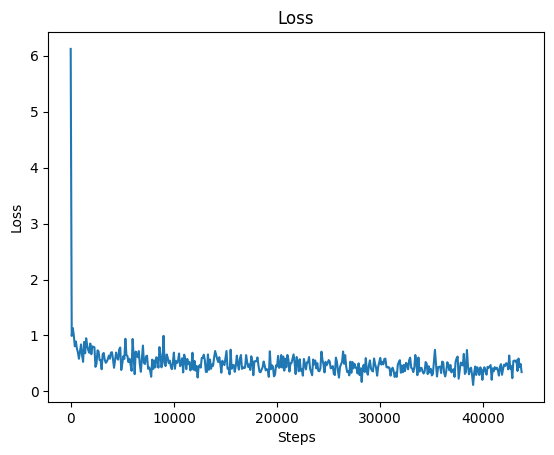

In [ ]:
import matplotlib.pyplot as plt

steps = [i*100 for i in range(len(loss_per_10_steps))]

plt.plot(steps, loss_per_10_steps)
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

## Testing the model

In [ ]:
model.eval()
input_ids = tokenizer.encode("WebNLG: sidharth | hometown | Delhi && sidharth | play |  football </s>", return_tensors="pt")  # Batch size 1
input_ids=input_ids.to(dev)
outputs = model.generate(input_ids)
tokenizer.decode(outputs[0])

'<pad> Sidharth, whose hometown is in Delhi, plays football.</s>'

Before testing the model further, lets learn how to serialize it and load from the path

## Serializing the trained model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.save(model.state_dict(),'/content/drive/MyDrive/LS_NLP_Final_Project/pytoch_model.bin')


## Downloading the config file

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

!wget https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json

--2023-08-08 20:13:46--  https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.182.40.88, 54.231.134.144, 54.231.230.96, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.182.40.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1199 (1.2K) [application/json]
Saving to: ‘t5-base-config.json’

t5-base-config.json 100%[===================>]   1.17K  --.-KB/s    in 0s      

2023-08-08 20:13:47 (63.9 MB/s) - ‘t5-base-config.json’ saved [1199/1199]



In [ ]:
#model=torch.load("/content/pytoch_model.bin")

## Loading the trained model from the path

In [ ]:
model = T5ForConditionalGeneration.from_pretrained('/content/pytoch_model.bin', return_dict=True,config='t5-base-config.json')


## The Inference function

In [ ]:
def generate(text):
  model.eval()
  input_ids = tokenizer.encode("WebNLG:{} </s>".format(text), return_tensors="pt")  # Batch size 1
  # input_ids.to(dev)
  s = time.time()
  outputs = model.generate(input_ids)
  gen_text=tokenizer.decode(outputs[0]).replace('<pad>','').replace('</s>','')
  elapsed = time.time() - s
  print('Generated in {} seconds'.format(str(elapsed)[:4]))


  return gen_text

In [ ]:
pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.2/294.2 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.3/140.3 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mdit-py-plugins to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 5.0 MB/s eta 0:00:00
   

In [ ]:
import gradio as gr



# Define the Gradio interface
iface = gr.Interface(
    fn=generate,  # Replace with your actual function
    inputs=gr.inputs.Textbox(lines=2, placeholder="Enter text here..."),
    outputs=gr.outputs.Textbox(),
    title="Text Generation App",
    description="Enter some text and see the generated output.",
)

# Launch the Gradio interface
iface.launch()


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

# Now, Lets test it out !

In [ ]:
generate('Russia | leader | Putin')

Generated in 0.64 seconds


' The leader of Russia is Putin.'

In [ ]:
generate('Sidhath | profession | Doctor  && Sidharth | home_town |  Bombay')

Generated in 1.47 seconds


'Sidhath, a doctor, is a doctor in the city of Bomba'

In [ ]:
generate('Nie_Haisheng | birthDate | 1964-10-13  && Nie_Haisheng | occupation | Fighter_pilot ')

Generated in 1.17 seconds


'Born on October 13th, 1964, Nie Haisheng served as a fighter pilot.'

In [ ]:
generate('Bananaman | creator | Steve_Bright &&  Bananaman | broadcastedBy | BBC')

In [ ]:
generate('Bananaman | lastAired | "1986-04-15" && Bananaman | creator | Steve_Bright')

In [ ]:
generate('Alan_B._Miller_Hall | currentTenants | Mason_School_of_Business && Alan_B._Miller_Hall | location | Williamsburg,_Virginia')